# Load packages

In [1]:
from hydromt_wflow import WflowModel
import matplotlib.pyplot as plt 
import toml
import pandas as pd

C:\Users\Nienke Tempel\hydromt_wflow\hydromt_wflow\wflow.py:10: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd
C:\Users\Nienke Tempel\anaconda3\envs\hydromt-wflow\lib\site-packages\hydromt\io.py:14: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now

# Load model

In [2]:
root = r"C:\Users\Nienke Tempel\Documents\Thesis\11. Model\Model\for_nienke_mike\wflow_flextopo"
config_fn = "wflow_flextopo.toml"
mod = WflowModel(root = root, config_fn = config_fn, mode = "r")
ds = mod.staticmaps

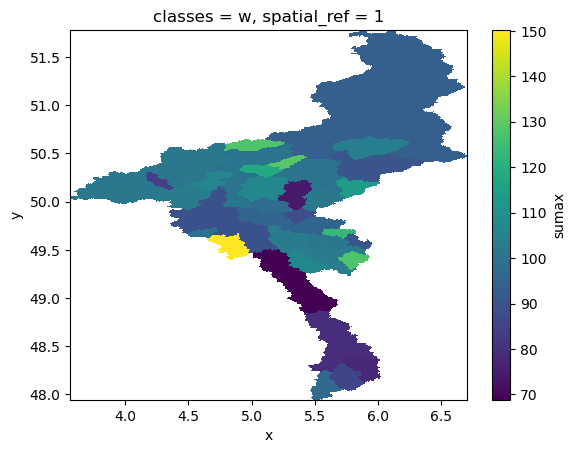

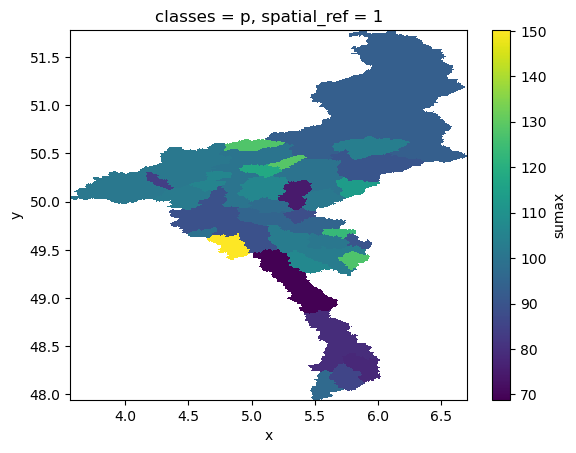

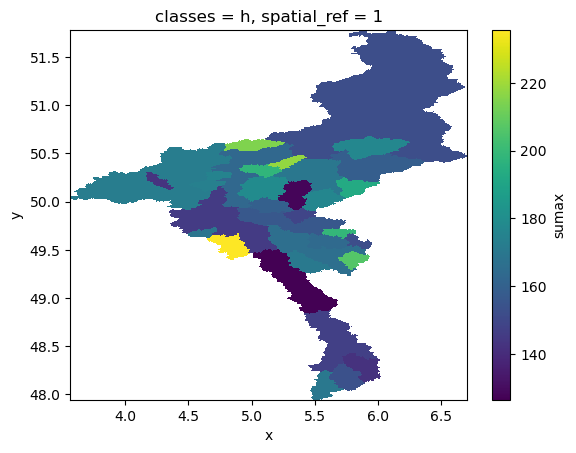

In [3]:
plt.figure(); ds["sumax"].sel(classes="w").raster.mask_nodata().plot()
plt.figure(); ds["sumax"].sel(classes="p").raster.mask_nodata().plot()
plt.figure(); ds["sumax"].sel(classes="h").raster.mask_nodata().plot()

## Change runtime

In [4]:
# Modify the starttime and endtime
mod.config['starttime'] = '1999-01-01T00:00:00'
mod.config['endtime'] = '2008-12-31T00:00:00'
# mod.config['starttime'] = '2009-01-01T00:00:00'
# mod.config['endtime'] = '2018-12-31T00:00:00'
mod.config

{'casename': 'wflow_meuse',
 'calendar': 'proleptic_gregorian',
 'starttime': '1999-01-01T00:00:00',
 'endtime': '2008-12-31T00:00:00',
 'time_units': 'days since 1900-01-01 00:00:00',
 'timestepsecs': 86400,
 'silent': False,
 'loglevel': 'debug',
 'path_log': 'log.txt',
 'fews_run': False,
 'state': {'path_input': 'instate/instates.nc',
  'path_output': 'outstate/outstates.nc',
  'lateral': {'river': {'reservoir': {'volume': 'volume_reservoir'},
    'q': 'q_river',
    'h': 'h_river',
    'h_av': 'h_av_river'},
   'land': {'q': 'q_land', 'h': 'h_land', 'h_av': 'h_av_land'}},
  'vertical': {'snow': 'snow',
   'snowwater': 'snowwater',
   'interceptionstorage': 'interceptionstorage',
   'hortonpondingstorage': 'hortonpondingstorage',
   'hortonrunoffstorage': 'hortonrunoffstorage',
   'rootzonestorage': 'rootzonestorage',
   'faststorage': 'faststorage',
   'slowstorage': 'slowstorage'}},
 'input': {'path_forcing': '../inmaps/eobs_v20_1980_2018_corrP_remapnn_semisstonn.nc',
  'path_sta

## Load Srmax values

In [5]:
gdf = mod.staticgeoms["subcatch_Sall"].copy()
gdf.index = gdf["wflow_subcatch_Sall"]
gdf = gdf.drop(columns="wflow_subcatch_Sall")

In [6]:
gdf
wflow_ids = gdf.loc[gdf['geometry'] != None].index.values

In [7]:
# mod.staticgeoms["subcatch_Sall"].plot(edgecolor="k");

In [8]:
for v in range(1):
    print(v)

0


In [9]:
for v in range(100):
    SRmax_v = pd.read_csv(f'C:/Users/Nienke Tempel/Documents/Thesis/6. Code/9_TOML/1_Input/SRA2/SRmax_{v+1}.csv')
    for i in range(len(gdf)):
        wflow = gdf.index[i]
        wflow_int=int(wflow)
        subcatch = gdf.iloc[i]
        if wflow_int in wflow_ids:
            if wflow_int in SRmax_v['WFLOW'].values:
                gdf.loc[wflow_int, 'sumax_w'] = SRmax_v.loc[SRmax_v['WFLOW'] == wflow_int, 'Sr_2'].values[0]
                gdf.loc[wflow_int, 'sumax_p'] = SRmax_v.loc[SRmax_v['WFLOW'] == wflow_int, 'Sr_2'].values[0]
                gdf.loc[wflow_int, 'sumax_h'] = SRmax_v.loc[SRmax_v['WFLOW'] == wflow_int, 'Sr_20'].values[0]

            else:
                gdf.loc[wflow_int, 'sumax_w'] = SRmax_v.loc[SRmax_v['WFLOW'] == 16, 'Sr_2'].values[0]
                gdf.loc[wflow_int, 'sumax_p'] = SRmax_v.loc[SRmax_v['WFLOW'] == 16, 'Sr_2'].values[0]
                gdf.loc[wflow_int, 'sumax_h'] = SRmax_v.loc[SRmax_v['WFLOW'] == 16, 'Sr_20'].values[0]
                
    sumax_w = ds["sumax"].raster.rasterize(gdf, col_name="sumax_w")
    sumax_p = ds["sumax"].raster.rasterize(gdf, col_name="sumax_p")
    sumax_h = ds["sumax"].raster.rasterize(gdf, col_name="sumax_h")

    #make a copy of sumax maps in staticmaps
    sumax_v_classes = ds["sumax"].copy()
    
    #overwrite sumax plateau class with new values
    sumax_v_classes.loc[dict(classes="p")] = sumax_p

    #overwrite sumax wetland class with new values
    sumax_v_classes.loc[dict(classes="w")] = sumax_w

    #overwrite sumax hillslope class with new values
    sumax_v_classes.loc[dict(classes="h")] = sumax_h
    
    #add the new sumax maps to the staticmaps
    sumax_v_classes.name = "sumax_v"
    
    mod.set_staticmaps(sumax_v_classes)
    mod.set_config("input.vertical.srmax","sumax_v")
    mod.set_config("input.path_static", "staticmaps_flex_meuse.nc")
    mod.set_config("input.path_forcing", "../for_nienke_mike/inmaps/eobs_v20_1980_2018_corrP_remapnn_semisstonn.nc")
    mod.staticmaps.raster.set_crs("EPSG:4326")
    
    mod.set_root(f"C:/Users/Nienke Tempel/Documents/Thesis/11. Model/Model/flextopo_SRA2_{v+1}")
    mod.write_staticmaps()
    mod.write_config()
    mod.write_staticgeoms()

In [10]:
# mod.staticmaps

## Check if maps is right

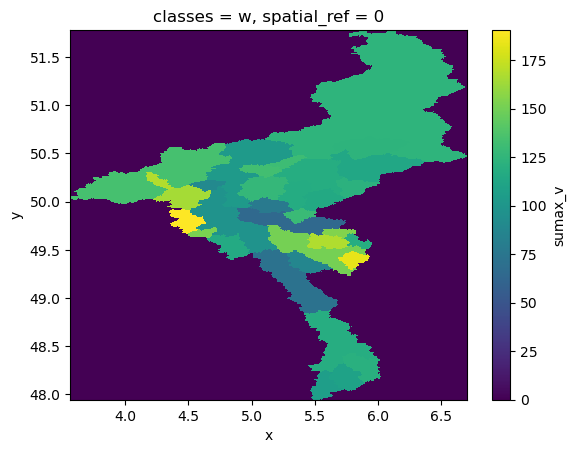

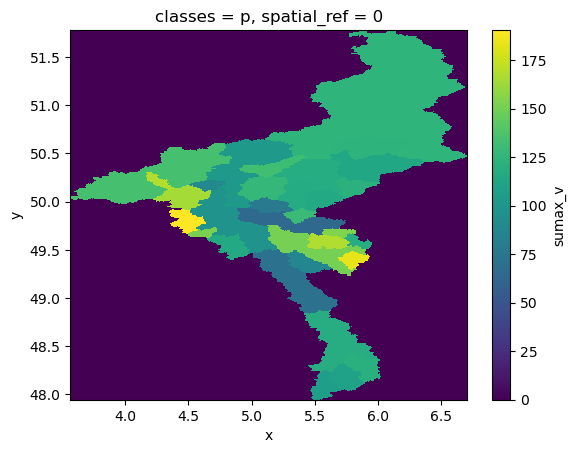

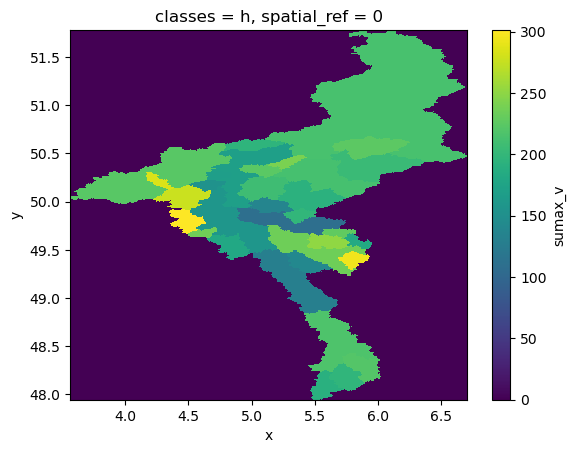

In [11]:
plt.figure(); sumax_v_classes.sel(classes="w").raster.mask_nodata().plot()
plt.figure(); sumax_v_classes.sel(classes="p").raster.mask_nodata().plot()
plt.figure(); sumax_v_classes.sel(classes="h").raster.mask_nodata().plot()